In [130]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
import dash_daq as daq
from dash import html
from dash import dash_table
from dash.dependencies import Input, Output
import psycopg2
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import os
import plotly.figure_factory as ff
import plotly.express as px
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
import dash_bootstrap_components as dbc

In [2]:
engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'.format(
    user = 'postgres',
    password = POSTGRES_PASSWORD,
    host = 'postgres',
    port = 5432,
    db = 'neurodash'
))

In [3]:
external_stylesheets = [dbc.themes.BOOTSTRAP]

In [ ]:
data['neuron_id'].value_counts()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data.dtypes)

In [10]:
mymarkdown = '''
NeuroDash is a dashboard to view the current neuroscience literature. The data for this dashobard come from [NeuroMorpho](https://neuromorpho.org/), [NeuroElectro](https://neuroelectro.org/), and [ModelDB](https://modeldb.science/). NeuroMorpho provides morphological data for neurons researchers find. NeuroElectro provides information about the electrophysiological properties of neurons found in the literature. Lastly, ModelDB provides information about computation neual models that researchers have created. These resources combine to illustrate research trends and findings in Neuroscience. They can serve as a jumping off point for someone looking to do their own research.
'''

In [21]:
myquery = '''
SELECT primary_brain_region, 
    COUNT(*) AS n_neurons
FROM neuron
GROUP BY primary_brain_region
ORDER BY n_neurons
    DESC
'''
data = pd.read_sql_query(myquery, con = engine)
primary_brain_regions = [x for x in data['primary_brain_region']].remove(None)

In [124]:
measurements = ['soma_surface', 'n_stems', 'n_bifs', 'n_branch', 'width', 'height', 'depth', 'diameter', 'length']

In [142]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        html.H1("NeuroDash"),
        html.H2("Data collected from NeuroMorpho, NeuroElectro, & ModelDB"),
        html.H3("DS 6600: Data Engineering 1, UVA Data Science"),
        html.Div([
            dcc.Markdown('''Pick a Primary Brain Region to Study'''),
            dcc.Dropdown(id = 'primary_brain_region', options = primary_brain_regions, value = 'neocortex'),
            dcc.Markdown(mymarkdown)
        ], style = {'width': '24%', 'float': 'left'}),
        html.Div([
            dcc.Tabs([
                dcc.Tab(label = 'NeuroMorpho', children = [
                    # stuff for NeuroMorpho Goes Here
                    dcc.Markdown('''Select a Measure to Graph:'''),
                    dcc.Dropdown(id = 'measurement', options = measurements, value = 'soma_surface'),
                    daq.BooleanSwitch(id = 'log', label = 'Logarithmic Measurement', on = False),
                    dcc.Graph(id = 'NeuronMeasurementGraph'),
                    html.Div([dcc.Graph(id = 'NeuronRegionTable')])
                ]),
                dcc.Tab(label = 'NeuroElectro', children = [
                    # stuff for NeuroElectro goes Here
                    
                ]),
                dcc.Tab(label = 'ModelDB', children = [
                    # stuff for ModelDB goes here
                    
                ])
            ])
        ], style = {'width': '74%', 'float': 'right'})
    ]
)

@app.callback([Output(component_id = 'NeuronRegionTable', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value')])

def NeuronRegionTable(primary_brain_region):
    myquery = f'''
    SELECT ROUND(AVG(soma_surface)) AS soma_surface,
        ROUND(AVG(n_stems)) AS number_stems,
        ROUND(AVG(n_bifs)) AS number_biffurcations,
        ROUND(AVG(n_branch)) AS number_branches,
        ROUND(AVG(width)) AS width,
        ROUND(AVG(height)) AS height,
        ROUND(AVG(depth)) AS depth,
        ROUND(AVG(diameter)) AS diameter,
        ROUND(AVG(length)) AS length
    FROM neuron
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)
    data['primary_brain_region'] = pd.Series([primary_brain_region])
    
    table = ff.create_table(data[['primary_brain_region', 'soma_surface', 'number_stems', 'number_biffurcations',
       'number_branches', 'width', 'height', 'depth', 'diameter', 'length']])
    return [table]

@app.callback([Output(component_id = 'NeuronMeasurementGraph', component_property = 'figure')],
             [Input(component_id = 'primary_brain_region', component_property = 'value'),
             Input(component_id = 'measurement', component_property = 'value'),
             Input(component_id = 'log', component_property = 'on')])

def NeuronMeasurement(primary_brain_region, measurement, log):
    myquery = f'''
    SELECT {measurement}
    FROM neuron
    WHERE primary_brain_region = '{primary_brain_region}'
    '''
    data = pd.read_sql_query(myquery, con = engine)
    title = 'Box plot for Neuron ' + measurement + ' in the ' + primary_brain_region
    if log:
        xaxis = 'Log Measurement of ' + measurement
    else:
        xaxis = measurement
    fig = px.box(x = data[measurement], log_x = log, title = title)
    fig.update_layout(xaxis_title = xaxis)

    return [fig]

# Execution
if __name__ == "__main__":
    app.run_server(mode='external', host = '0.0.0.0', port = 8050, debug = True)

In [50]:
primary_brain_region = 'neocortex'
myquery = f'''
SELECT *
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)

In [51]:
neuron_columns = [x for x in data.columns]

In [57]:
data.columns

Index(['neuron_id', 'neuron_name', 'archive', 'note', 'age_scale', 'gender',
       'age_classification', 'species', 'strain', 'scientific_name', 'stain',
       'protocol', 'slicing_direction', 'reconstruction_software',
       'objective_type', 'original_format', 'magnification', 'upload_date',
       'deposition_date', 'shrinkage_reported', 'shrinkage_corrected',
       'reported_value', 'reported_xy', 'reported_z', 'corrected_value',
       'corrected_xy', 'corrected_z', 'surface_x', 'volume_x',
       'slicing_thickness', 'min_age', 'max_age', 'min_weight', 'max_weight',
       'png_url', 'physical_integrity', '_links.self.href',
       '_links.measurements.href', '_links.persistence_vector.href',
       'brain_region_len', 'primary_brain_region', 'secondary_brain_region',
       'tertiary_brain_region', 'dendrites', 'soma', 'axon', 'processes',
       'neurites', 'att_diameter', 'att_angles', 'att_3d', 'surface_y',
       'volume_y', 'soma_surface', 'n_stems', 'n_bifs', 'n_branch

In [102]:
# gender, age_classification, species, png_url, primary_brain_region, dendrites, soma, axon, processes, neurites, soma_surface, n_stems, n_biffs, n_branch, width, height, depth, diameter, length
primary_brain_region = 'neocortex'
myquery = f'''
SELECT ROUND(AVG(soma_surface)) AS soma_surface,
    ROUND(AVG(n_stems)) AS number_stems,
    ROUND(AVG(n_bifs)) AS number_biffurcations,
    ROUND(AVG(n_branch)) AS number_branches,
    ROUND(AVG(width)) AS width,
    ROUND(AVG(height)) AS height,
    ROUND(AVG(depth)) AS depth,
    ROUND(AVG(diameter)) AS diameter,
    ROUND(AVG(length)) AS length
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)
data['primary_brain_region'] = pd.Series([primary_brain_region])

table = ff.create_table(data[['primary_brain_region', 'soma_surface', 'number_stems', 'number_biffurcations',
   'number_branches', 'width', 'height', 'depth', 'diameter', 'length']])

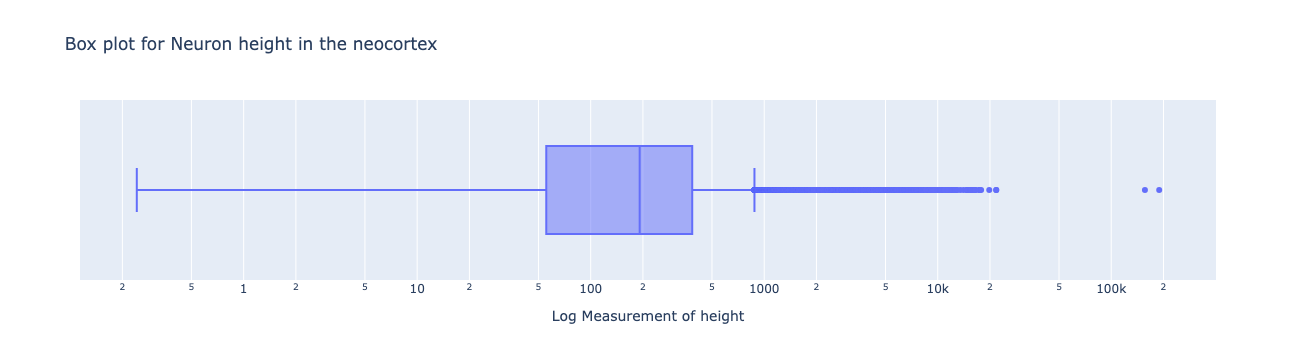

In [123]:
primary_brain_region = 'neocortex'
measurement = 'height'
log = True
myquery = f'''
SELECT {measurement}
FROM neuron
WHERE primary_brain_region = '{primary_brain_region}'
'''
data = pd.read_sql_query(myquery, con = engine)
title = 'Box plot for Neuron ' + measurement + ' in the ' + primary_brain_region
if log:
    xaxis = 'Log Measurement of ' + measurement
else:
    xaxis = measurement
fig = px.box(x = data[measurement], log_x = log, title = title)
fig.update_layout(xaxis_title = xaxis)